In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, matthews_corrcoef

import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
df = pd.read_csv('sample_data/final_df_activity_v2.csv')
df

,gyro_x,gyro_y,gyro_z,acceleration_x,acceleration_y,acceleration_z,target
0,181,-3007,2892,5,-7,-2,0
1,185,-3010,2878,6,-7,-2,0
2,187,-3012,2892,6,-7,-2,0
3,186,-3009,2887,6,-7,-2,0
4,184,-3011,2888,6,-7,-2,0
...,...,...,...,...,...,...,...
52831,-4116,-1226,746,-174,-183,34,2
52832,-3750,-1417,789,-325,-36,-87,2
52833,-3811,-1375,806,311,90,-139,2
52834,-3775,-1227,902,19,34,62,2


In [3]:
X = df.drop(columns = ['target'])
y = df['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 42, 
                                                    shuffle = True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
    
  def __len__(self):
    return self.len

In [7]:
BATCH_SIZE = 64
INPUT_DIM = 6
HIDDEN_LAYERS = 25
OUTPUT_DIM = 3

In [8]:
train_data = Data(X_train.to_numpy(), y_train.to_numpy())
test_data = Data(X_test.to_numpy(), y_test.to_numpy())

train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [9]:
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.linear1 = nn.Linear(INPUT_DIM, HIDDEN_LAYERS)
    self.linear2 = nn.Linear(HIDDEN_LAYERS, HIDDEN_LAYERS * 2)
    self.dropout = nn.Dropout(0.2)
    self.linear3 = nn.Linear(HIDDEN_LAYERS * 2, HIDDEN_LAYERS)
    self.linear4 = nn.Linear(HIDDEN_LAYERS, OUTPUT_DIM)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    x = self.dropout(x)
    x = torch.relu(self.linear3(x))
    x = self.linear4(x)
    return x

In [10]:
NN = NN().to(device)
summary(NN, (1, 6))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 25]             175
            Linear-2                [-1, 1, 50]           1,300
           Dropout-3                [-1, 1, 50]               0
            Linear-4                [-1, 1, 25]           1,275
            Linear-5                 [-1, 1, 3]              78
Total params: 2,828
Trainable params: 2,828
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [11]:
print(NN)

NN(
  (linear1): Linear(in_features=6, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=50, out_features=25, bias=True)
  (linear4): Linear(in_features=25, out_features=3, bias=True)
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NN.parameters(), lr = 0.001)

In [13]:
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
  loop = tqdm(train_loader)
  for batch, (X, y) in enumerate(loop):
    X, y = X.to(device), y.to(device)

    pred = NN(X)

    loss = criterion(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
    loop.set_postfix(loss = loss.item())

Epoch [19/20]: 100%|██████████| 578/578 [00:03<00:00, 175.53it/s, loss=0.255]


In [14]:
correct, total = 0, 0
list_pred, list_true = [], []

with torch.no_grad():
  for (X, y) in test_loader:
    X, y = X.to(device), y.to(device)

    output = NN(X)
    pred = output.argmax(dim = 1, keepdim = True)
    list_pred.append(pred.cpu().numpy())
    list_true.append(y.cpu().numpy())
    correct += pred.eq(y.view_as(pred)).sum().item()
accuracy = correct / len(test_loader.dataset)
print(f'Accuracy: {accuracy:>0.4f} %')

Accuracy: 0.8896 %


In [15]:
list_pred = np.concatenate(list_pred)
list_pred = np.hstack(list_pred).tolist()
list_true = np.concatenate(list_true)
list_true = np.hstack(list_true).tolist()
cm = confusion_matrix(list_pred, list_true)
cm

array([[4336,  176,  388],
       [ 397, 5183,  286],
       [ 381,  122, 4582]])

In [16]:
nn_AS_test = accuracy_score(list_pred, list_true)
nn_BAS_test = balanced_accuracy_score(list_pred, list_true)
nn_f1_weighted_test = f1_score(list_pred, list_true, average = 'weighted')
nn_mcc_test = matthews_corrcoef(list_pred, list_true)

nn_test_scores_dict = {'Accuracy' : nn_AS_test,
                       'Balanced accuracy' : nn_BAS_test,
                       'F1 score' : nn_f1_weighted_test,
                       'Matthews correlation coefficient' : nn_mcc_test}

nn_test_scores_df = pd.DataFrame.from_dict(nn_test_scores_dict, orient = 'index', columns = ['Scores'])

nn_test_scores_df

,Scores
Accuracy,0.889597
Balanced accuracy,0.889849
F1 score,0.890066
Matthews correlation coefficient,0.834769


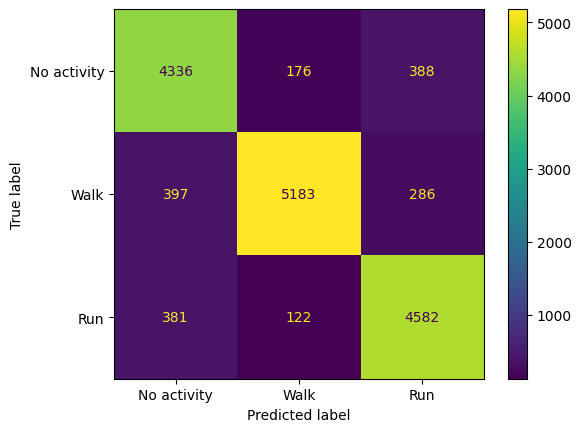

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No activity', 'Walk', 'Run'])
disp.plot()
plt.show()